In [12]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

from model_training import create_model, prepare_images
from PIL import Image
from tensorflow.keras.preprocessing.image import array_to_img
from matplotlib.pyplot import imshow
%matplotlib inline

Variabili Globali dei Path del modello e del Validation Set

In [13]:
MODEL_PATH      = './deep_undeeper224.model' # path del modello allenato
VALIDATION_PATH = './ilsvrc2012Validation'   # path del dataset di validazione (1001 imgs)

Carico il modello gia' allenato

In [14]:
model = create_model()                      # creo il modello
model = keras.models.load_model(MODEL_PATH) # carico il modello allenato

Riassunto del modello

In [15]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 512)     14336     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 512)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 512)     2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 256)     1179904   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 256)       1024  

Perparo le immagini di Validazione per essere passate al modello.
Imposto il parametro `shuffle=False` per evitare che le immagini vengano mischiate ogni volta e quindi per averle nello stesso ordine di come si trovano nella cartella.

In [34]:
validation :DirectoryIterator = prepare_images(VALIDATION_PATH, shuffle=False)

Found 1001 images belonging to 1 classes.


Effettuo la fase di Evaluation per verificare il valore Loss

In [6]:
result_eval = model.evaluate(validation)
print(f'\nLoss: {result_eval} ({model.metrics_names})')

126/126 [==============================] - 13s 61ms/step - loss: 0.0042

Loss: 0.004245703108608723 (['loss'])


Definisco la funzione che mi permettera' di convertire il `DirectoryIterator` in un `numpy.array` per effettuare piu' facilmente le operazioni successive sulle varie immagini.

In [16]:
def dirIterator_to_array(iter: DirectoryIterator) -> np.array:
    """ Converte un DirectoryIterator in numpy.arry

        Parameters:
            iter (DirectoryIterator): DirectoryIterator da trasformare in array
        
        Return:
            numpy.array: array con tutte le immagini generate da DirectoryIterator
    """
    
    data_list = []
    batch_index = 0

    while batch_index <= iter.batch_index:
        data = iter.next()
        tmp = data[0]
        for elem in tmp:
            data_list.append(elem)

        batch_index = batch_index + 1

    data_array = np.array(data_list)

    return data_array

Trasformo il `DirectoryIterator` in `numpy.arry` e prendo tutti i nomi delle immagini.

I nomi delle immagini hanno lo stesso ordine delle immagini effettive:
    
* `validation_names[i]` corrispondera' al nome della foto `validation_np[i]`

In [35]:
validation_np    :np.array = dirIterator_to_array(validation) # trasforma DirectoryIterator in np.arry
validation_names :np.array = np.array(validation.filenames)   # prende i nomi di tutte le immaigni

Passo al modello le immagini di Validazione

In [36]:
result_predict :np.array = model.predict(validation)

Stampo le prime 15 immagini per effettuare un confronto tra quelle originali e quelle ricostruite dal modello

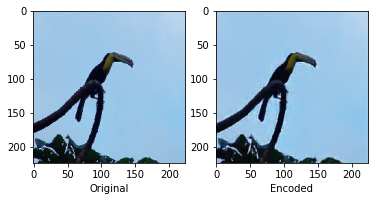

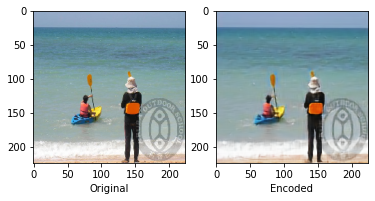

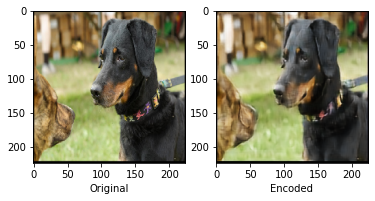

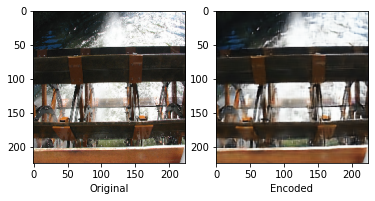

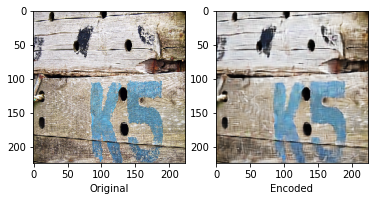

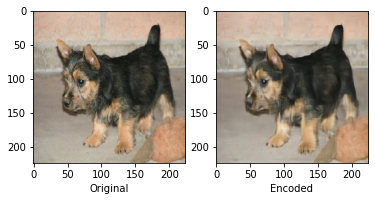

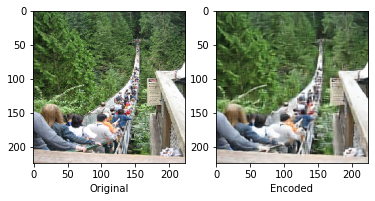

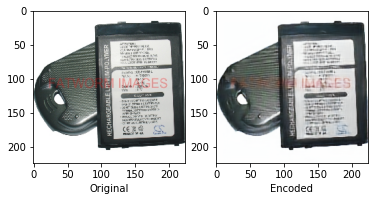

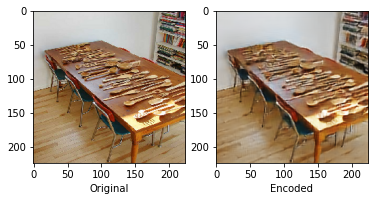

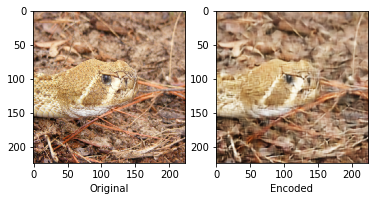

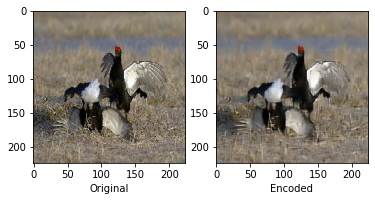

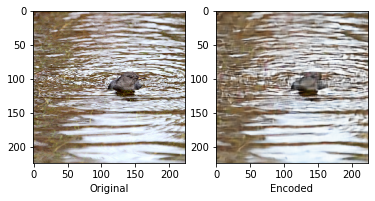

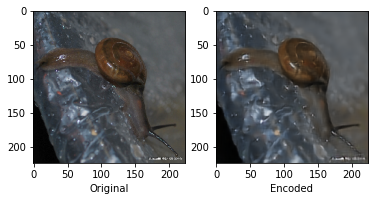

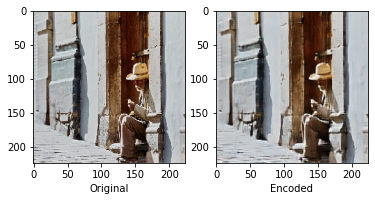

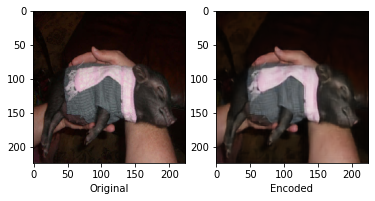

In [10]:
for i in range(15):
    f, axarr = plt.subplots(1,2)       # (y, x) suddivide la singola riga in 2 parti

    axarr[0].set_xlabel('Original')
    axarr[0].imshow(validation_np[i])
    
    axarr[1].set_xlabel('Encoded')
    axarr[1].imshow(result_predict[i])


Calcolo l'errore di ricostruzione per ogni immagine e trovo le immagini 'distorte' e quelle 'pulite'

In [37]:
errori          = np.array([])  # array con i risultati finali
conta_distorta  = 0             # immagine non appartenenti al dataset di origine
conta_pulita    = 0             # immagini appartenenti al dataset di origine
treshold        = 0.87          # treshold di attivazione per considerare un'immagine pulita (<= treshold) o distorata (> treshold)
i               = 0             # contatore per accedere alle posizioni dei 2 array

for i in range(len(validation_np)):
    errore = (np.square(validation_np[i] - result_predict[i])).mean()   # calcola l'errore (??)
    errore = errore * 100
    errori = np.append(errori, errore)

    # conta quante sono le immagini considerate 'distorte' e quelle 'pulite'
    if errore > treshold :
        conta_distorta += 1
    else:
        conta_pulita += 1

print('')
print(f"immagini pulite = {conta_pulita} ({conta_pulita/len(validation_np)*100}%)")
print(f"immagini distorte =  {conta_distorta} ({conta_distorta/len(validation_np)*100}%)")
print(f"media errore dataset = {np.mean(errori)}")


immagini pulite = 879 (87.81218781218782%)
immagini distorte =  122 (12.187812187812188%)
media errore dataset = 0.4245702447332479


Creo una classe per contenere i dati delle singole immagini:
    
* nome
* errore
* immagine stessa

In [27]:
class ImgData:
    def __init__(self, name: str, data: np.array, errore: float):
        self.name = name
        self.data = data
        self.errore = errore
    
    def __repr__(self):
        return f'{self.name},{self.errore}'

Creo una lista con gli oggetti che rappresentano le immagini di Validazione e le ordino in base all'errore

In [38]:
imgs = []

for i in range(len(validation_np)):
    imgs.append(ImgData(validation_names[i], validation_np[i], errori[i]))

# funzione che serve per ordinare gli oggetti della lista in base al parametro errore
def get_my_key(obj):
    return obj.errore

imgs.sort(key=get_my_key)

validation_sorted = [x.errore for x in imgs]

Stampo i nomi delle immagini con i relativi errori

In [17]:
for img in imgs:
    print(str(img).replace(',', '\t'))

original/ILSVRC2012_val_00030176.JPEG	0.007258335244841874
original/ILSVRC2012_val_00030644.JPEG	0.026497000362724066
original/ILSVRC2012_val_00030664.JPEG	0.028983945958316326
original/ILSVRC2012_val_00030457.JPEG	0.02996940747834742
original/ILSVRC2012_val_00030444.JPEG	0.031148764537647367
original/ILSVRC2012_val_00030184.JPEG	0.0338426063535735
original/ILSVRC2012_val_00030136.JPEG	0.03571696870494634
original/ILSVRC2012_val_00030333.JPEG	0.03688725701067597
original/ILSVRC2012_val_00030014.JPEG	0.03797189274337143
original/ILSVRC2012_val_00030769.JPEG	0.03835138340946287
original/ILSVRC2012_val_00030535.JPEG	0.03919313021469861
original/ILSVRC2012_val_00030183.JPEG	0.03976153675466776
original/ILSVRC2012_val_00030718.JPEG	0.043006869964301586
original/ILSVRC2012_val_00030574.JPEG	0.04344532499089837
original/ILSVRC2012_val_00030194.JPEG	0.04449411353562027
original/ILSVRC2012_val_00030464.JPEG	0.04454485315363854
original/ILSVRC2012_val_00030468.JPEG	0.0451914151199162
original/IL

Stampo a video il grafico degli errori delle immagini di Validazione

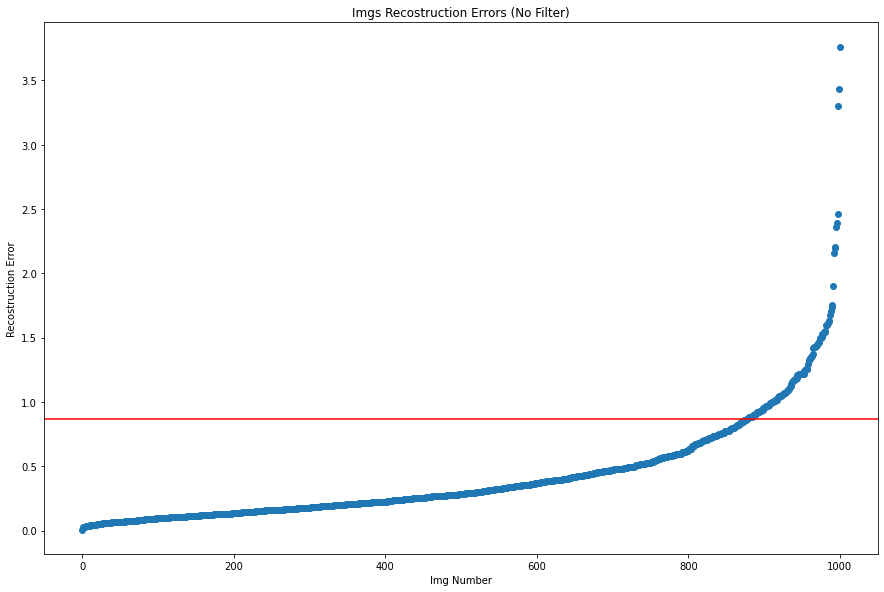

In [39]:
x = np.array(range(len(validation_sorted))) # ad ogni immagine associo un numero crescente
y = np.array([x.errore for x in imgs])      # ottengo solo l'errore dagli oggetti

px = 1/plt.rcParams['figure.dpi']       # pixel in inches
plt.figure(figsize=(900*px, 600*px))    # dimensione della figura (w, h)

# setto le varie scritte da aggiungere al grafico
plt.title('Imgs Recostruction Errors (No Filter)')
plt.xlabel('Img Number')
plt.ylabel('Recostruction Error')

plt.tight_layout()
plt.scatter(x, y)                       # stampa gli errori delle immagini
plt.axhline(y=treshold, color='red')    # stampa la linea della treshold

plt.savefig('errori_chart_sorted.png', dpi=300)    # stampa il grafico ad alta risoluzione


## Immagini Filtrate

Applico i filtri di Diego alle immagini di validazione. Utilizzo un solo seed.

Per effettuare questa parte e' necessario lo script presente all'interno della cartella `dataset_adapter`. E' stato leggermente modificato per evitare di aggiungere tutte le immagini in una cartella con il nome della propria classe.

In [18]:
%cd dataset_adapter
%ls

!python adapter.py -i ../ilsvrc2012Validation/original -o ./test --diego --noadapt --seed 69

%cd ..

%mkdir ilsvrc2012ValidationFiltered69
%mkdir ilsvrc2012ValidationFiltered69/filtered69
%cp -r dataset_adapter/Filtered/*.JPEG ilsvrc2012ValidationFiltered69/filtered69

/tf/notebooks/dataset_adapter
ILSVRC2014_clsloc_validation_ground_truth.txt*  diego/   map_clsloc.txt*
adapter.py*                                     gimgum/
**** SEED 69 ****
ILSVRC2012_val_00030226.JPEG
ILSVRC2012_val_00030311.JPEG
ILSVRC2012_val_00030719.JPEG
ILSVRC2012_val_00030527.JPEG
ILSVRC2012_val_00030888.JPEG
ILSVRC2012_val_00030453.JPEG
ILSVRC2012_val_00030846.JPEG
ILSVRC2012_val_00030756.JPEG
ILSVRC2012_val_00030279.JPEG
ILSVRC2012_val_00030951.JPEG
ILSVRC2012_val_00030060.JPEG
ILSVRC2012_val_00030561.JPEG
ILSVRC2012_val_00030363.JPEG
ILSVRC2012_val_00030051.JPEG
ILSVRC2012_val_00030581.JPEG
ILSVRC2012_val_00030798.JPEG
ILSVRC2012_val_00030442.JPEG
ILSVRC2012_val_00030974.JPEG
ILSVRC2012_val_00030540.JPEG
ILSVRC2012_val_00030313.JPEG
ILSVRC2012_val_00030866.JPEG
ILSVRC2012_val_00030143.JPEG
ILSVRC2012_val_00030832.JPEG
ILSVRC2012_val_00030862.JPEG
ILSVRC2012_val_00030451.JPEG
ILSVRC2012_val_00030052.JPEG
ILSVRC2012_val_00030327.JPEG
ILSVRC2012_val_00030089.JPEG
ILSVRC2012_

ILSVRC2012_val_00030629.JPEG
ILSVRC2012_val_00030717.JPEG
ILSVRC2012_val_00030160.JPEG
ILSVRC2012_val_00030531.JPEG
ILSVRC2012_val_00030989.JPEG
ILSVRC2012_val_00030487.JPEG
ILSVRC2012_val_00030385.JPEG
ILSVRC2012_val_00030818.JPEG
ILSVRC2012_val_00030414.JPEG
ILSVRC2012_val_00030131.JPEG
ILSVRC2012_val_00030018.JPEG
ILSVRC2012_val_00030426.JPEG
ILSVRC2012_val_00030684.JPEG
ILSVRC2012_val_00030278.JPEG
ILSVRC2012_val_00030084.JPEG
ILSVRC2012_val_00030396.JPEG
ILSVRC2012_val_00030166.JPEG
ILSVRC2012_val_00030342.JPEG
ILSVRC2012_val_00030528.JPEG
ILSVRC2012_val_00030499.JPEG
ILSVRC2012_val_00030408.JPEG
ILSVRC2012_val_00030177.JPEG
ILSVRC2012_val_00030112.JPEG
ILSVRC2012_val_00030847.JPEG
ILSVRC2012_val_00030535.JPEG
ILSVRC2012_val_00030427.JPEG
ILSVRC2012_val_00030562.JPEG
ILSVRC2012_val_00030901.JPEG
ILSVRC2012_val_00030919.JPEG
ILSVRC2012_val_00030365.JPEG
ILSVRC2012_val_00030418.JPEG
ILSVRC2012_val_00030351.JPEG
ILSVRC2012_val_00030472.JPEG
ILSVRC2012_val_00030683.JPEG
ILSVRC2012_val

ILSVRC2012_val_00030871.JPEG
ILSVRC2012_val_00030040.JPEG
ILSVRC2012_val_00030693.JPEG
ILSVRC2012_val_00030672.JPEG
ILSVRC2012_val_00030286.JPEG
ILSVRC2012_val_00030232.JPEG
ILSVRC2012_val_00030410.JPEG
ILSVRC2012_val_00030330.JPEG
ILSVRC2012_val_00030755.JPEG
ILSVRC2012_val_00030425.JPEG
ILSVRC2012_val_00030153.JPEG
ILSVRC2012_val_00030513.JPEG
ILSVRC2012_val_00030249.JPEG
ILSVRC2012_val_00030681.JPEG
ILSVRC2012_val_00030644.JPEG
ILSVRC2012_val_00030927.JPEG
ILSVRC2012_val_00030456.JPEG
ILSVRC2012_val_00030444.JPEG
ILSVRC2012_val_00030971.JPEG
ILSVRC2012_val_00030075.JPEG
ILSVRC2012_val_00030107.JPEG
ILSVRC2012_val_00030329.JPEG
ILSVRC2012_val_00030042.JPEG
ILSVRC2012_val_00030897.JPEG
ILSVRC2012_val_00030202.JPEG
ILSVRC2012_val_00030678.JPEG
ILSVRC2012_val_00030485.JPEG
ILSVRC2012_val_00030491.JPEG
ILSVRC2012_val_00030605.JPEG
ILSVRC2012_val_00030222.JPEG
ILSVRC2012_val_00030119.JPEG
ILSVRC2012_val_00030944.JPEG
ILSVRC2012_val_00030566.JPEG
ILSVRC2012_val_00030466.JPEG
ILSVRC2012_val

ILSVRC2012_val_00030625.JPEG
ILSVRC2012_val_00030464.JPEG
ILSVRC2012_val_00030128.JPEG
ILSVRC2012_val_00030497.JPEG
ILSVRC2012_val_00030251.JPEG
ILSVRC2012_val_00030937.JPEG
ILSVRC2012_val_00030736.JPEG
ILSVRC2012_val_00030261.JPEG
ILSVRC2012_val_00030219.JPEG
ILSVRC2012_val_00030102.JPEG
ILSVRC2012_val_00030070.JPEG
ILSVRC2012_val_00030495.JPEG
ILSVRC2012_val_00030726.JPEG
ILSVRC2012_val_00030025.JPEG
ILSVRC2012_val_00030820.JPEG
ILSVRC2012_val_00030473.JPEG
ILSVRC2012_val_00030170.JPEG
ILSVRC2012_val_00030646.JPEG
ILSVRC2012_val_00030305.JPEG
ILSVRC2012_val_00030671.JPEG
ILSVRC2012_val_00030310.JPEG
ILSVRC2012_val_00030168.JPEG
ILSVRC2012_val_00030306.JPEG
ILSVRC2012_val_00030909.JPEG
ILSVRC2012_val_00030565.JPEG
ILSVRC2012_val_00030280.JPEG
ILSVRC2012_val_00030776.JPEG
ILSVRC2012_val_00030799.JPEG
ILSVRC2012_val_00030277.JPEG
ILSVRC2012_val_00030807.JPEG
ILSVRC2012_val_00030036.JPEG
ILSVRC2012_val_00030110.JPEG
ILSVRC2012_val_00030056.JPEG
ILSVRC2012_val_00030236.JPEG
ILSVRC2012_val

Preparo le immagini Filtrate per passarle al Modello.

In [20]:
filtered :DirectoryIterator = prepare_images('./ilsvrc2012ValidationFiltered69', shuffle=False)

Found 1001 images belonging to 1 classes.


Passo al modello le immagini filtrate e salvo il risultato

In [21]:
result_predict_filtered :np.array = model.predict(filtered)


Converto il `DirectoryIterato` in `numpy.array` e prendo i nomi delle immagini

In [22]:
filtered_np    :np.array = dirIterator_to_array(filtered) # trasforma DirectoryIterator in np.arry
filtered_names :np.array = np.array(filtered.filenames)   # prende i nomi di tutte le immaigni

Confronto tra immagini `Vere` e `Ricostruite`

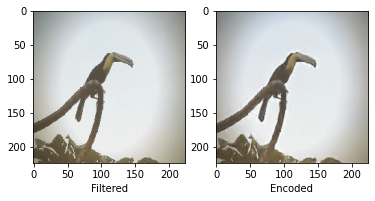

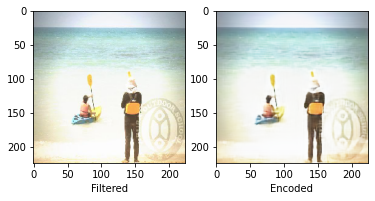

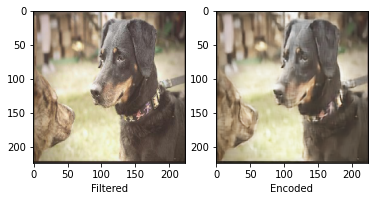

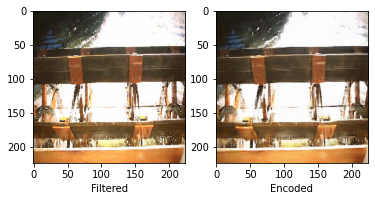

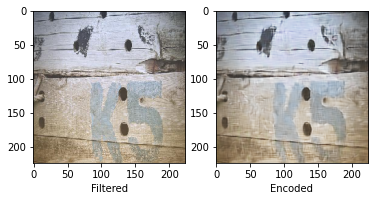

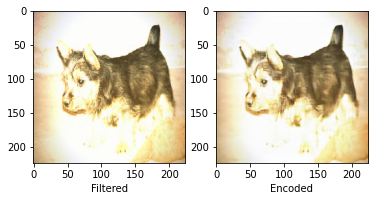

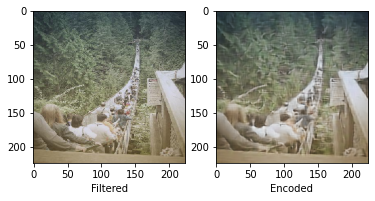

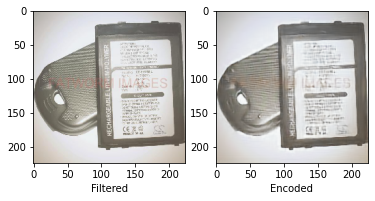

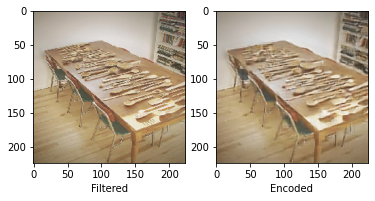

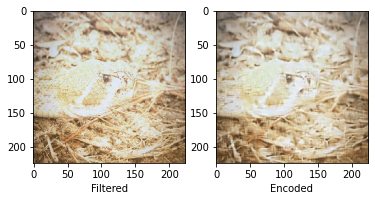

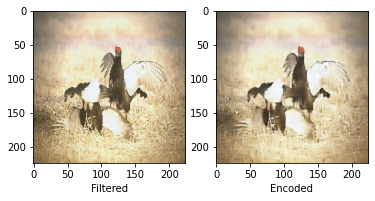

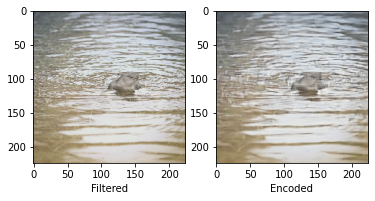

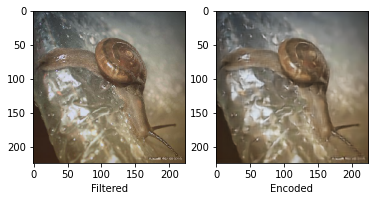

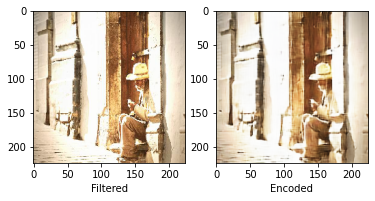

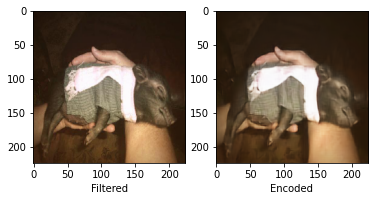

In [23]:
for i in range(15):
    f, axarr = plt.subplots(1,2)       # (y, x) suddivide la singola riga in 2 parti

    axarr[0].set_xlabel('Filtered')
    axarr[0].imshow(filtered_np[i])
    
    axarr[1].set_xlabel('Encoded')
    axarr[1].imshow(result_predict_filtered[i])

Calcolo l'errore di ricostruzione per ogni immagine e trovo le immagini 'distorte' e quelle 'pulite'

In [24]:
errori_filtered = np.array([])  # array con i risultati finali
conta_distorta  = 0             # immagine non appartenenti al dataset di origine
conta_pulita    = 0             # immagini appartenenti al dataset di origine
treshold        = 0.87          # treshold di attivazione per considerare un'immagine pulita (<= treshold) o distorata (> treshold)
i               = 0             # contatore per accedere alle posizioni dei 2 array

for i in range(len(filtered_np)):
    errore = (np.square(filtered_np[i] - result_predict_filtered[i])).mean()   # calcola l'errore (??)
    errore = errore * 100
    errori_filtered = np.append(errori_filtered, errore)

    # conta quante sono le immagini considerate 'distorte' e quelle 'pulite'
    if errore > treshold :
        conta_distorta += 1
    else:
        conta_pulita += 1

print('')
print(f"immagini pulite = {conta_pulita} ({conta_pulita/len(filtered_np)*100}%)")
print(f"immagini distorte =  {conta_distorta} ({conta_distorta/len(filtered_np)*100}%)")
print(f"media errore dataset = {np.mean(errori_filtered)}")


immagini pulite = 933 (93.20679320679321%)
immagini distorte =  68 (6.793206793206793%)
media errore dataset = 0.32699670514307466


Ordino le immagini filtrate in modo crescente per l'errore di ricostruzione.

In [29]:
imgs_filtered = []

for i in range(len(filtered_np)):
    imgs_filtered.append(ImgData(filtered_names[i], filtered_np[i], errori_filtered[i]))

# funzione che serve per ordinare gli oggetti della lista in base al parametro errore
def get_my_key(obj):
    return obj.errore

imgs_filtered.sort(key=get_my_key)

filtered_sorted = [x.errore for x in imgs_filtered]

Stampo i nomi delle immagini con il relativo errore

In [30]:
for img in imgs_filtered:
    print(str(img).replace(',', '\t'))

filtered69/ILSVRC2012_val_00030566.JPEG	0.01644448930164799
filtered69/ILSVRC2012_val_00030176.JPEG	0.01693732338026166
filtered69/ILSVRC2012_val_00030664.JPEG	0.017967275925911963
filtered69/ILSVRC2012_val_00030457.JPEG	0.02019367675529793
filtered69/ILSVRC2012_val_00030098.JPEG	0.021274380560498685
filtered69/ILSVRC2012_val_00030091.JPEG	0.022398254077415913
filtered69/ILSVRC2012_val_00030348.JPEG	0.022504823573399335
filtered69/ILSVRC2012_val_00030644.JPEG	0.02290027478011325
filtered69/ILSVRC2012_val_00030225.JPEG	0.02441025135340169
filtered69/ILSVRC2012_val_00030440.JPEG	0.024985044728964567
filtered69/ILSVRC2012_val_00030612.JPEG	0.02519705449230969
filtered69/ILSVRC2012_val_00030769.JPEG	0.02526759635657072
filtered69/ILSVRC2012_val_00030909.JPEG	0.027024911832995713
filtered69/ILSVRC2012_val_00030278.JPEG	0.027047813637182117
filtered69/ILSVRC2012_val_00030859.JPEG	0.028173316968604922
filtered69/ILSVRC2012_val_00030435.JPEG	0.028314709197729826
filtered69/ILSVRC2012_val_00030

Stampo il grafico degli errori delle immagini con Filtri

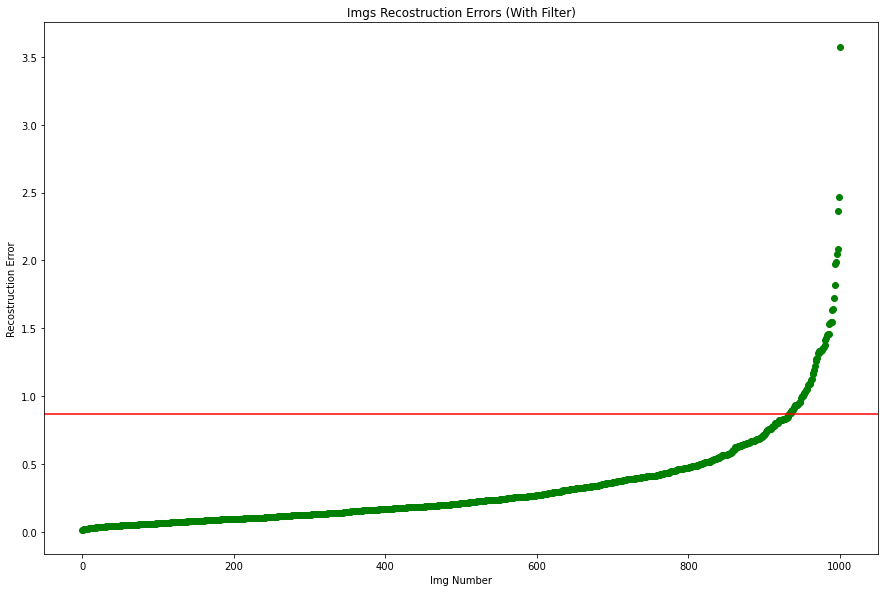

In [43]:
x = np.array(range(len(filtered_sorted)))            # ad ogni immagine associo un numero crescente
y = np.array([x.errore for x in imgs_filtered])      # ottengo solo l'errore dagli oggetti

px = 1/plt.rcParams['figure.dpi']       # pixel in inches
plt.figure(figsize=(900*px, 600*px))    # dimensione della figura (w, h)

# setto le varie scritte da aggiungere al grafico
plt.title('Imgs Recostruction Errors (With Filter)')
plt.xlabel('Img Number')
plt.ylabel('Recostruction Error')

plt.tight_layout()
plt.scatter(x, y, color='green')        # stampa gli errori delle immagini
plt.axhline(y=treshold, color='red')    # stampa la linea della treshold

plt.savefig('errori_chart_sorted_filtered.png', dpi=300)    # stampa il grafico ad alta risoluzione

Stampo il grafico dove metto a confronto gli errori di ricostruzione delle immagini CON e SENZA filtri applicati.

* in `rosso` e' indicata la Threshold oltre la quale le immagini vengono considerate `distorte`
* in `blu` sono indicate le immagini SENZA filtri applicati
* in `verde` sono indicate le immagini CON filtri applicati

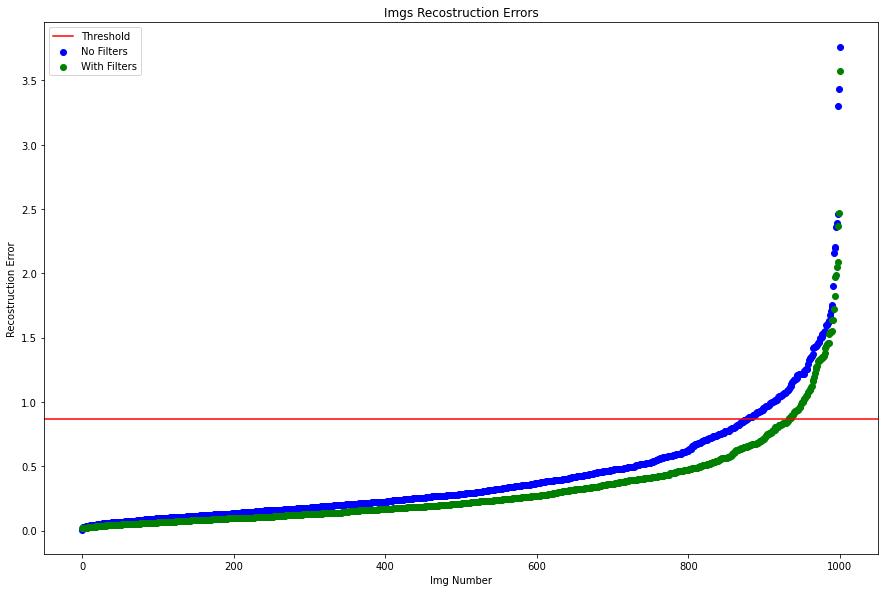

In [44]:
x = np.array(range(len(filtered_sorted)))            # ad ogni immagine associo un numero crescente
y_filter = np.array([x.errore for x in imgs_filtered])      # ottengo solo l'errore dagli oggetti
y_original = y = np.array([x.errore for x in imgs])      # ottengo solo l'errore dagli oggetti

px = 1/plt.rcParams['figure.dpi']       # pixel in inches
plt.figure(figsize=(900*px, 600*px))    # dimensione della figura (w, h)

# setto le varie scritte da aggiungere al grafico
plt.title('Imgs Recostruction Errors')
plt.xlabel('Img Number')
plt.ylabel('Recostruction Error')

plt.tight_layout()

plt.scatter(x, y_original, color='blue', label='No Filters')        # stampa gli errori delle immagini
plt.scatter(x, y_filter, color='green', label='With Filters')        # stampa gli errori delle immagini
plt.axhline(y=treshold, color='red', label='Threshold')    # stampa la linea della treshold

plt.legend()
plt.savefig('errori_chart_sorted_all.png', dpi=300)    # stampa il grafico ad alta risoluzione